In [2]:
# !pip install --upgrade --no-cache-dir gdown -q
# !gdown https://drive.google.com/uc?id=1gLlvBML_-2msH5u2MuKEGKXJ2FzVWEUe -O data1.zip
# !gdown https://drive.google.com/uc?id=1XEPn0xxN0l7A6RzOEguCj_27smE361Fq -O data2.zip
# !unzip -qnd . ./data1.zip
# !unzip -qnd . ./data2.zip

In [3]:
from scipy import ndimage
import cv2
import os
import random
from google.colab.patches import cv2_imshow
import numpy as np
from PIL import Image
import json
from matplotlib import pyplot as plt
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization


(<matplotlib.axes._subplots.AxesSubplot at 0x7f3eb218b950>,
 Text(0.5, 1.0, 'sample from second dataset'))

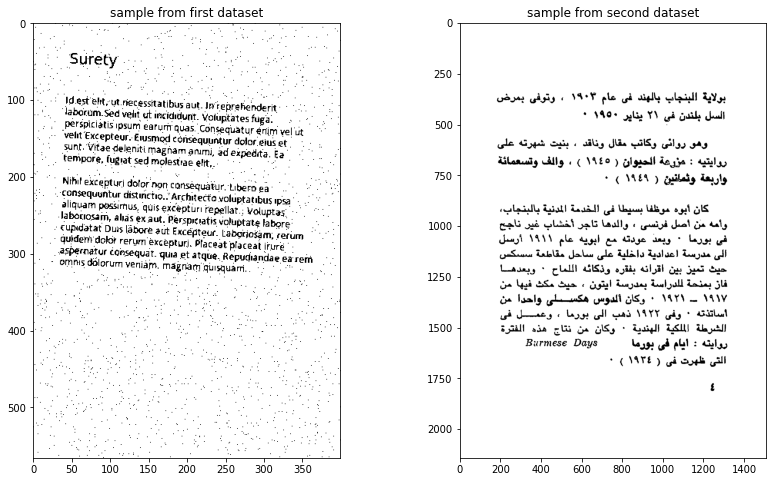

In [4]:
img1=cv2.imread('scan_doc_rotation/images/scan_001.png')
img2=cv2.imread('/content/animal_farm/1_Page_001.png')
plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(img1),plt.title('sample from first dataset')
plt.subplot(122),plt.imshow(img2),plt.title('sample from second dataset')

In [5]:
print('shapes of images in each dataset:', img1.shape, img2.shape)

shapes of images in each dataset: (566, 400, 3) (2142, 1509, 3)


In [6]:
## Function to rotate, resize, lable and save images
def rotate_images(input_path, angle, output_path):
  img = cv2.imread(input_path, cv2.IMREAD_UNCHANGED)
  rotated = ndimage.rotate(img, angle, mode='wrap')
  resized = cv2.resize(rotated, (400, 566), interpolation = cv2.INTER_AREA)
  cv2.imwrite(output_path, resized)

Test rotation and resize function


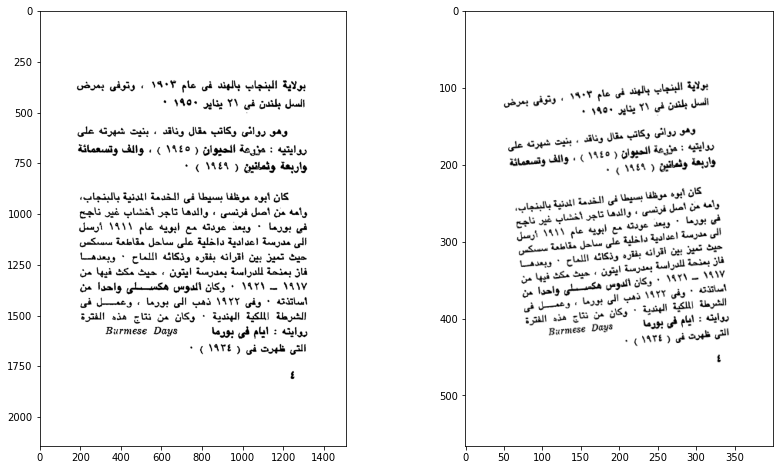

In [7]:
## Test rotation and resize function
path ='/content/animal_farm/1_Page_001.png'
rotate_images(path, 5, '1.png')
plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(cv2.imread(path))
plt.subplot(122),plt.imshow(cv2.imread('1.png'))
print('Test rotation and resize function')

In [8]:
## Rotate, resize, lable and save the animal farm book dataset
input_path = 'animal_farm'
output_path = 'scan_doc_rotation/images'
labels_path = 'scan_doc_rotation/labels'
imgs = os.listdir('animal_farm')
n = 0
for i in tqdm(imgs):
  for j in range(10):
    angle = random.randint(-5, 5)
    name = str(n)
    rotate_images(f'{input_path}/{i}', angle, f'{output_path}/{name}.png')
    with open(f'{labels_path}/{name}.txt', 'w') as f:
      f.write(str(angle))
    n+=1

100%|██████████| 185/185 [17:37<00:00,  5.72s/it]


['0.png', '1.png', '10.png', '100.png', '1000.png', '1001.png', '1002.png', '1003.png', '1004.png', '1005.png']
Total number of images: 2450


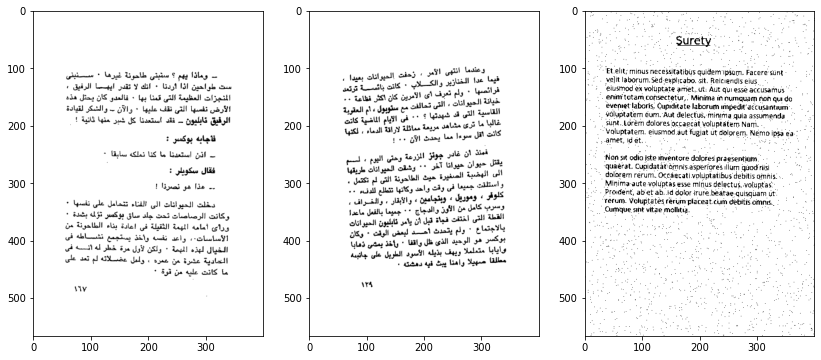

In [9]:
# Load and open images
path = 'scan_doc_rotation'
names = [file for file in os.listdir(f'{path}/images/') ]
names = sorted(names)
N = len(names)
print(names[:10])

# Load some images to check
images = [Image.open(f'{path}/images/'+names[random.randint(0,N)]) for i in range(3)]

plt.figure(figsize=(14,8))
plt.subplot(131),plt.imshow(images[0], cmap = 'gray')
plt.subplot(132),plt.imshow(images[1], cmap = 'gray')
plt.subplot(133),plt.imshow(images[2], cmap = 'gray')

print('Total number of images: %d'%N)

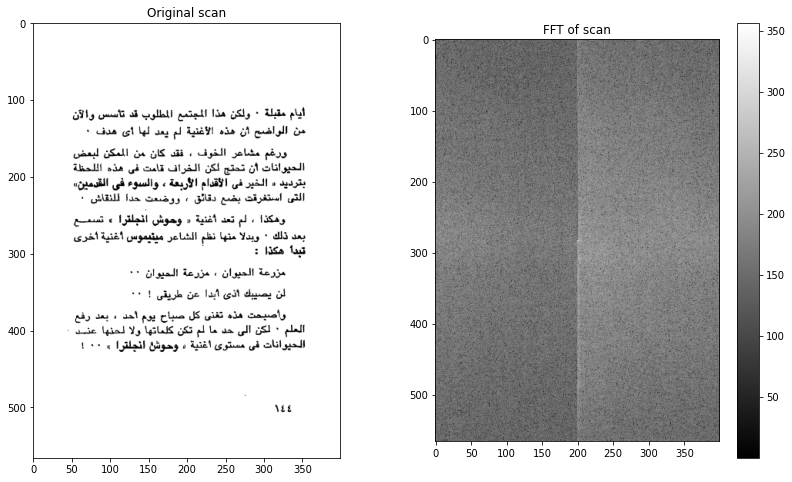

In [40]:
eg_img = f'{path}/images/'+names[18]
img = cv2.imread(eg_img)
img = img[:,:,0] #zeroth component is the red from RGB channel ordering
f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0 #shift to ensure no zeroes are present in image array
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))

plt.subplot(121),plt.imshow(img, 'gray')
plt.title('Original scan')

plt.subplot(122),plt.imshow(f_img, 'gray')
plt.title('FFT of scan')
plt.colorbar() 
plt.show()

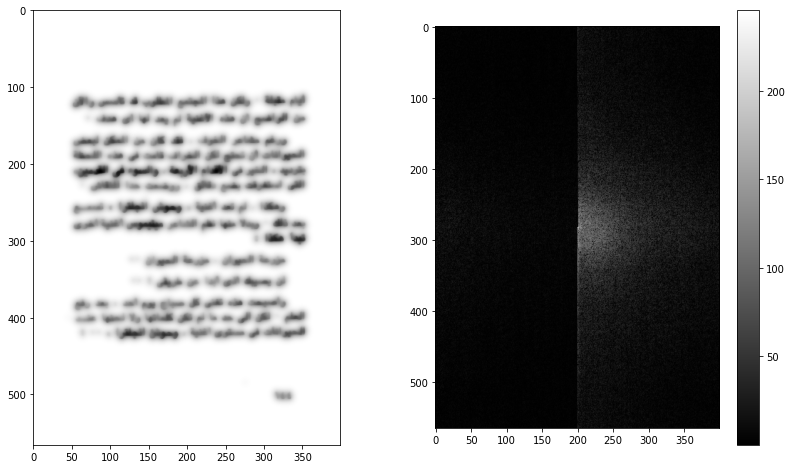

In [41]:
from skimage.restoration import denoise_tv_chambolle

img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)
                               
f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(img, 'gray')
plt.subplot(122),plt.imshow(f_img, 'gray')
os.system('mkdir -p ./processed')
cv2.imwrite('processed/'+names[10], f_img)
plt.colorbar() 
plt.show()

In [43]:
fft_images = []
for i in tqdm(range(N)):
    img = cv2.imread(path+'/images/'+names[i])
    img = img[:,:,0]
    img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)
    f = cv2.dft(np.float32(img))
    fshift = np.fft.fftshift(f)
    f_abs = np.abs(fshift) + 1.0 # shift to avoid np.log(0) = nan
    f_img = 20 * np.log(f_abs)
    fft_images.append(f_img)
    cv2.imwrite('processed/'+names[i], f_img)

100%|██████████| 2450/2450 [37:57<00:00,  1.08it/s]


In [78]:

mydict = fft_images
output = open('myfile.pkl', 'wb')
pickle.dump(mydict, output)
output.close()

In [79]:
!cp -r /content/myfile.pkl /content/drive/MyDrive